# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [7]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head(10)

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1
5,1202.691891,24.419542,23.749025,0
6,1437.802287,23.072481,15.420813,1
7,1377.361197,16.820030,19.836601,0
8,1708.295820,32.325865,5.113337,1
9,1069.650343,27.163300,23.808491,1


## 1) Train/Test Split

In [ ]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)


Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

print(len(Xf_train), len(Xf_test))
print(len(Xr_train), len(Xr_test)) # Printed just to observe

900 300
900 300


## 2) Fit Both Logistic Regression Models

In [ ]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.

clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score

thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5

# Compute metrics
acc_full = accuracy_score(yf_test, ypred_full)
prec_full = precision_score(yf_test, ypred_full)
rec_full = recall_score(yf_test, ypred_full)

acc_reduced = accuracy_score(yr_test, ypred_reduced)
prec_reduced = precision_score(yr_test, ypred_reduced)
rec_reduced = recall_score(yr_test, ypred_reduced)

# Compute ROC-AUC and PR-AUC
roc_full = roc_auc_score(yf_test, yprob_full)
roc_reduced = roc_auc_score(yr_test, yprob_reduced)
pr_full = average_precision_score(yf_test, yprob_full)
pr_reduced = average_precision_score(yr_test, yprob_reduced)

# Display results
metrics = pd.DataFrame({
    'Model': ['Full (CAPE, PWAT, Shear)', 'Reduced (CAPE only)'],
    'Accuracy': [acc_full, acc_reduced],
    'Precision': [prec_full, prec_reduced],
    'Recall': [rec_full, rec_reduced],
    'ROC-AUC': [roc_full, roc_reduced],
    'PR-AUC': [pr_full, pr_reduced]
})
print(metrics.round(3))

                      Model  Accuracy  Precision  Recall  ROC-AUC  PR-AUC
0  Full (CAPE, PWAT, Shear)     0.723      0.733   0.678    0.812   0.818
1       Reduced (CAPE only)     0.717      0.736   0.651    0.791   0.798


## 4) Plot ROC and Precision–Recall Curves

/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


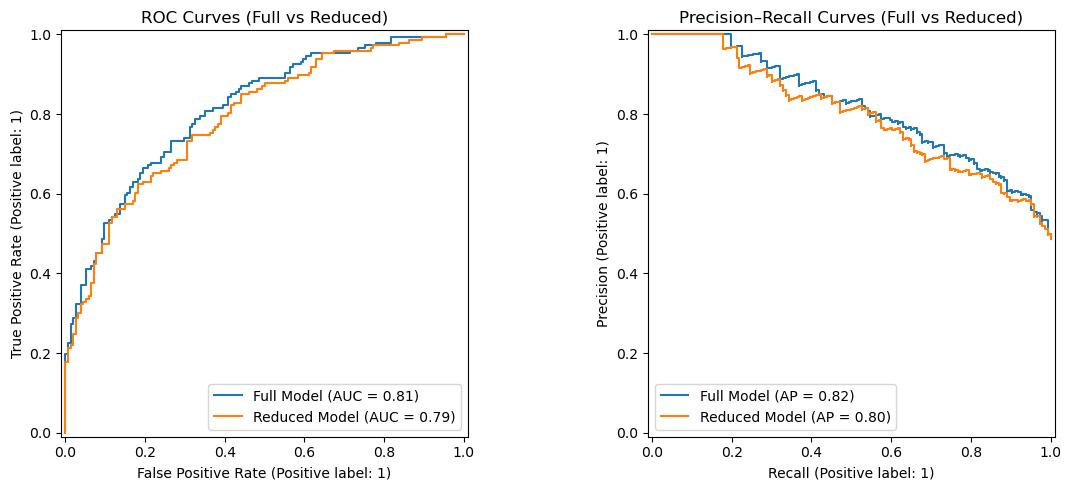

In [13]:
# TODO: Plot ROC and PR curves for both models on shared axes

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# --- ROC Curves ---
RocCurveDisplay.from_predictions(yf_test, yprob_full, name='Full Model', ax=ax1, color='C0')
RocCurveDisplay.from_predictions(yr_test, yprob_reduced, name='Reduced Model', ax=ax1, color='C1')
ax1.set_title("ROC Curves (Full vs Reduced)")

# --- Precision–Recall Curves ---
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, name='Full Model', ax=ax2, color='C0')
PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, name='Reduced Model', ax=ax2, color='C1')
ax2.set_title("Precision–Recall Curves (Full vs Reduced)")

plt.tight_layout()
plt.show()


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

| Metric | Full Model (CAPE, PWAT, Shear) | Reduced Model (CAPE only) | Which Performs Better? |
|:--------|:-------------------------------|:---------------------------|:------------------------|
| **Accuracy** | 0.723 | 0.717 | Full |
| **Precision** | 0.733 | 0.736 | Reduced |
| **Recall** | 0.678 | 0.651 | Full |
| **ROC–AUC** | 0.812 | 0.791 | Full |
| **PR–AUC** | 0.818 | 0.798 | Full |

### Summary

The **three-parameter logistic regression model** (`CAPE`, `PWAT`, `Shear`) shows a modest improvement in predictive skill compared to the **one-parameter model** using only `CAPE`. The full model achieves slightly higher **accuracy**, **recall**, and **AUC** values, while the reduced model yields marginally higher **precision**.

This indicates that including **precipitable water (PWAT)** and **vertical wind shear** helps the model detect more true events, though it introduces a small increase in false alarms. In contrast, the reduced model produces slightly fewer false positives but misses more true events.  

In physical terms, severe weather occurrence depends not only on atmospheric instability (CAPE) but also on the availability of moisture and wind shear — both critical for storm organization and intensity.

**Model choice by objective:**
- To **maximize event detection (recall)** → I would choose the **Full model**.  
- To **minimize false alarms (precision)** → I would choose the **Reduced model**.

**Conclusion:**  
> The three-parameter logistic regression model (CAPE, PWAT, Shear) provides slightly better overall skill and a more realistic representation of the physical processes leading to events, even at a small cost of additional false alarms/positives.